In [5]:
import torch
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from utils import *
from data import generate_data
from model import Boosting, MetaLearner

# set device
# device = set_device()
device = 'cpu'
dtype = torch.float32
torch.manual_seed(1)

# generate train and test data
fixed_type = 'linear' # linear, friedman3, hajjem
random_type = 'grouped' # grouped, spatial

X_train, F_train, Z_train, b_train, y_train, m_train = generate_data(mode='train', fixed_type=fixed_type, 
                                                            random_type=random_type, 
                                                            device=device, dtype=dtype)
X_test, F_test, Z_test, b_test, y_test, m_test = generate_data(mode='test', fixed_type=fixed_type, 
                                                       random_type=random_type, 
                                                       device=device, dtype=dtype)

# initialize parameters
lr = 0.2 # 0.01, 0.05, 0.1
max_iter = 100
threshold = 1e-2
n = len(y_train)

sigma2 = torch.tensor(1.0, requires_grad=True, device=device, dtype=dtype) # error term
L = torch.eye(m_train, device=device, requires_grad=True, dtype=dtype) # Sigma = LL^T

solution_path = {
    'nll': [], 
    'sigma2': [], 
    # 'F_mse': [], 
    'test_mse': [], 
}

In [6]:
# Gaussian process boosting
with tqdm(total=max_iter, desc="Training") as pbar:
    for i in range(max_iter):
        # update the error term
        with torch.no_grad():
            Psi = compute_Psi(Z_train, L, sigma2, n, device, dtype)
            Psi_inv = torch.inverse(Psi)

            # initialize meta learner and F
            if i == 0: 
                meta_learner = MetaLearner(y_train, X_train, Psi_inv, lr, device, dtype)
                F = meta_learner.F
            residual = y_train - F
            sigma2.copy_(sigma2 / n * (residual.T @ Psi_inv @ residual).item())

        # update the covariance matrix
        nll = negative_log_likelihood(Z_train, L, sigma2, n, y_train, F, device, dtype)
        nll.backward()
        with torch.no_grad():
            L -= lr * L.grad.tril()
            L.grad.zero_()

        # update F
        with torch.no_grad():
            f = Boosting(y_train, F, Psi_inv, X_train, device=device, dtype=dtype)
            F = meta_learner.update(f)

        # compute metrics
        with torch.no_grad():
            # train mse
            F_mse = torch.sqrt(torch.mean((F - F_train) ** 2)).item()

            # test mse
            y_pred = meta_learner.predict(X_test)
            test_mse = torch.sqrt(torch.mean((y_test - y_pred - Z_test @ b_test) ** 2)).item()
        
        # log
        pbar.set_postfix(NLL=f"{nll.item():.2f}", 
                         Var=f"{sigma2.detach().cpu().item():.2f}", 
                         F_MSE=f"{F_mse:.2f}", 
                         Test_MSE=f"{test_mse:.2f}")
        solution_path['nll'].append(nll.item())
        solution_path['sigma2'].append(sigma2.detach().cpu().item())
        # solution_path['F_mse'].append(F_mse)
        solution_path['test_mse'].append(test_mse)

        # check convergence 
        if len(solution_path['nll']) > 1 and np.abs(solution_path['nll'][-1] - solution_path['nll'][-2]) < threshold:
            print(f"GPBoost converges at iteration {i}")
            break
        pbar.update(1)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

----- Initialize Meta Learner -----


Training: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s, F_MSE=0.88, NLL=1109.73, Test_MSE=1.30, Var=0.47]


In [31]:
def plot(solution_path):
    name_map = {
        "nll": "Negative Log Likelihood", 
        "sigma2": "Error Variance", 
        "test_mse": "RMSE over Test Set"
    }
    num_metrics = len(solution_path)
    fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 5), sharey=False)

    if num_metrics == 1:
        axes = [axes]

    for i, (metric, values) in enumerate(solution_path.items()):
        if not isinstance(values, list) or not all(isinstance(v, (int, float)) for v in values):
            print(f"Skipping metric '{metric}' as it does not contain a valid list of floats.")
            continue

        ax = axes[i]
        ax.plot(values, label=name_map[metric], marker='o' if len(values) < 20 else None)
        ax.set_title(name_map[metric] ,fontsize=16)
        ax.set_xlabel("Iteration", fontsize=14)
        ax.grid(True)

        min_value = min(values)
        max_value = max(values)
        padding = (max_value - min_value) * 0.1  # add 10% padding to the y-axis
        ax.set_ylim(min_value - padding, max_value + padding)

    fig.text(-0.01, 0.5, "Metric Value", va="center", rotation="vertical", fontsize=14)
    plt.tight_layout()
   

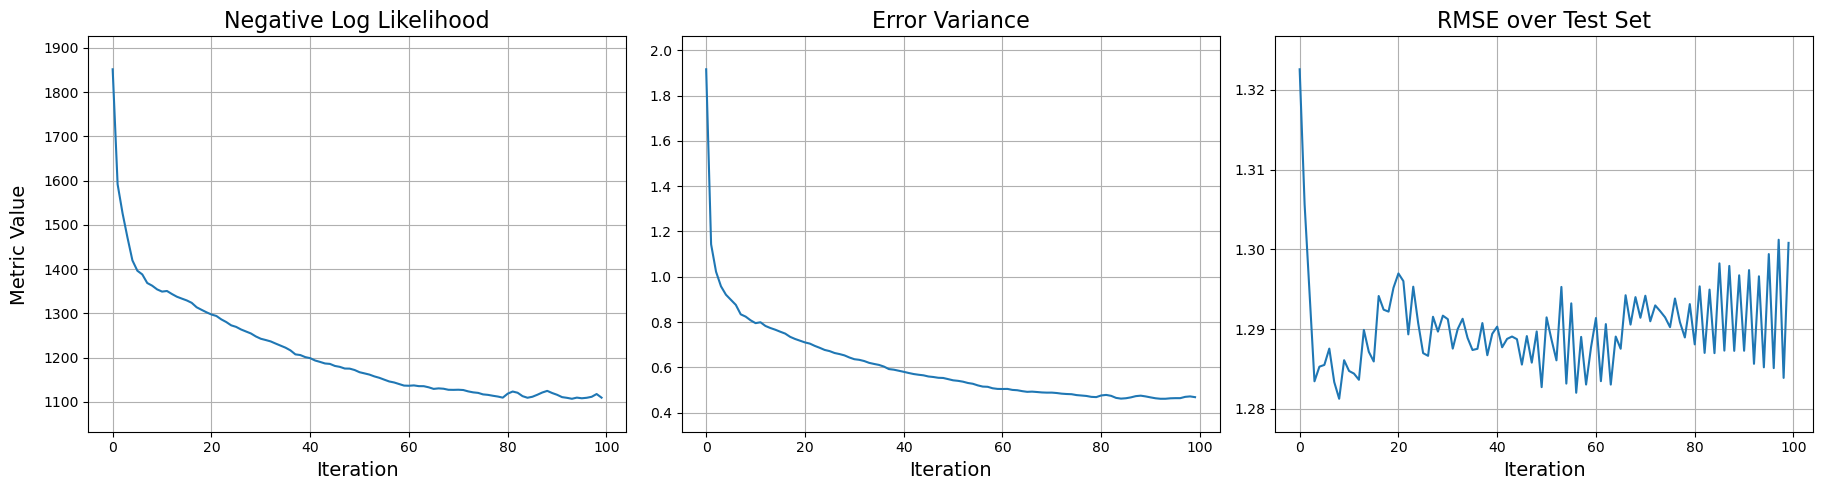

In [32]:
plot(solution_path)